# LDTk example 1: basics

This first example covers the basics of LDTk. We learn how to set up filters, how to use ``LDPSetCreator`` to create a set of limb darkening profiles as instances of ``LDPSet`` class, how to use these instances to estimate limb darkening coefficients from the profiles, and how to evaluate the limb darkening model likelihood directly from the profiles.

In [1]:
%pylab inline
from IPython.display import display, Latex
import seaborn as sb
sb.set_style('white')

Populating the interactive namespace from numpy and matplotlib


## Initialisation

In [2]:
from ldtk import LDPSetCreator, BoxcarFilter

In [3]:
filters = [BoxcarFilter('a',450,550),
           BoxcarFilter('b',650,750),
           BoxcarFilter('c',850,950)]

First, we initialise a ``LDPSetCreator`` with the stellar parameter estimates and our filter set. This may take some time, since we also need to download the necessary model spectra to a local cache directory (can be several hundreds of MB).

In [5]:
sc = LDPSetCreator(teff=(5400,50), logg=(4.5,0.1), z=(0.25,0.05), filters=filters)

Updating server file list: 100%|██████████| 9/9 [00:12<00:00,  1.13s/it]


Next, we create the limb darkening profiles with their uncertainties for each filter, all contained in an ``LDPSet`` object.

In [6]:
ps = sc.create_profiles(nsamples=2000)
ps.resample_linear_z()

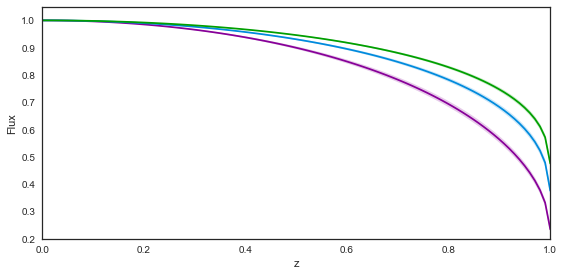

In [7]:
cp = cm.spectral(linspace(0.1,1.0,6))

fig,ax = subplots(1,1,figsize=(8,4), sharey=False)
for i in range(ps._nfilters)[:5]:
    c = cp[i]
    ax.fill_between(ps._z, ps._mean[i]-3*ps._std[i], ps._mean[i]+3*ps._std[i], facecolor=c, alpha=0.2)
    ax.plot(ps._z, ps._mean[i], '-', c=c)
setp(ax, xlim=(0,1), ylim=(0.2,1.05), xlabel='z', ylabel='Flux')
fig.tight_layout()

## Limb darkening coefficient estimation

The ``LDPSet`` class offers methods to estimate the limb darkening model coefficients for each filter. These methods are called ``coeffs_xx`` where ``xx`` can be

  - ``ln``:  linear model    (1 coeff)
  - ``qd``:  quadratic model (2 coeffs)
  - ``nl``:  nonlinear model (4 coeffs)
  - ``ge``:  general model   (n coeffs)
  
For the quadratic model

In [8]:
qc,qe = ps.coeffs_qd()

In [9]:
for i,(c,e) in enumerate(zip(qc,qe)):
    display(Latex('u$_{i:d} = {c[0]:5.4f} \pm {e[0]:5.4f}\quad$'
                  'v$_{i:d} = {c[1]:5.4f} \pm {e[1]:5.4f}$'.format(i=i+1,c=c,e=e)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

We can also use MCMC to estimate the coefficient uncertainties (or the full covariance matrix) more accurately:

In [10]:
qc,qe = ps.coeffs_qd(do_mc=True, n_mc_samples=10000)

In [11]:
for i,(c,e) in enumerate(zip(qc,qe)):
    display(Latex('u$_{i:d} = {c[0]:5.4f} \pm {e[0]:5.4f}\quad$'
                  'v$_{i:d} = {c[1]:5.4f} \pm {e[1]:5.4f}$'.format(i=i+1,c=c,e=e)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Finally, we can decide we don't trust the stellar models the profiles were computed from too much, and set an multiplicative factor on the profile uncertainties. 

In [12]:
ps.set_uncertainty_multiplier(2)

qc,qe = ps.coeffs_qd(do_mc=True, n_mc_samples=10000)

for i,(c,e) in enumerate(zip(qc,qe)):
    display(Latex('u$_{i:d} = {c[0]:5.4f} \pm {e[0]:5.4f}\quad$'
                  'v$_{i:d} = {c[1]:5.4f} \pm {e[1]:5.4f}$'.format(i=i+1,c=c,e=e)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Likelihood evaluation

We can also directly evaluate the likelihood for a model. This can be done for a single passband

In [13]:
print (ps.lnlike_qd([0.69, 0.15], flt=0))

415.339342388


jointly for all passbands

In [14]:
print (ps.lnlike_qd([ 0.69, 0.15,   0.48 ,0.16,   0.38, 0.15]))
print (ps.lnlike_qd([[0.69, 0.15], [0.48 ,0.16], [0.38, 0.15]]))

1572.29233483
1572.29233483


or separately for all passbands

In [15]:
print (ps.lnlike_qd([ 0.69, 0.15,   0.48, 0.16,   0.38, 0.15],  joint=False))
print (ps.lnlike_qd([[0.69, 0.15], [0.48, 0.16], [0.38, 0.15]], joint=False))

[ 415.33934239  552.87632492  604.07666752]
[ 415.33934239  552.87632492  604.07666752]


---
<center> &copy; 2015&ndash;2017 <a href="mailto:hannu.parviainen@physics.ox.ac.uk">Hannu Parviainen</a></center>